### Import librarys

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

In [2]:
#enable memory profiler for memory management usage %%memit 
from memory_profiler import memory_usage
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

In [3]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

Audio file loading control flag

In [4]:
# when set to TRUE, training data get loaded from a saved serialized data object file 
# All audio files data get saved to a serialized object file to save reloading time on training runs 
#
# Note: 
# On first time run, if serialized file doesn't exist, this flag will get overrident 
#
SKIP_AUDIO_RELOAD = False

### Dataset exploration

#### Ordner Struktur aus Kaggle Code

input/train/Train/fold1...

#### Ordner Struktur von mir

data/audio/fold1...

In [5]:
INPUT_PATH = 'data'

In [6]:
INPUT_FILE = INPUT_PATH+'/metadata/UrbanSound8K.csv'
AUDIO_DIR = INPUT_PATH+'/audio'

In [7]:
def load_input_data(pd, filepath):
    # Read Data
    data = pd.read_csv(filepath)
    return data

In [8]:
# show info
input = load_input_data(pd, INPUT_FILE)
input.rename(columns={'class': 'Class'}, inplace=True)
input.head()

,slice_file_name,fsID,start,end,salience,fold,classID,Class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
from sklearn.model_selection import train_test_split

train_input, test_input = train_test_split(input, train_size=0.6224, random_state=42)

In [10]:
# labels
valid_train_label = train_input[['Class']]
valid_train_label.count()

# unique classes
x = train_input.groupby('Class')['Class'].count()
x

Class
air_conditioner     627
car_horn            281
children_playing    632
dog_bark            624
drilling            619
engine_idling       635
gun_shot            226
jackhammer          610
siren               576
street_music        604
Name: Class, dtype: int64

In [11]:
valid_train_data = train_input[['slice_file_name', 'fold', 'classID', 'Class']]
valid_train_data.reset_index(drop=True)     # solange das df später nicht per Index angesprochen wird, macht das keine Probleme

,slice_file_name,fold,classID,Class
0,203929-7-7-0.wav,2,7,jackhammer
1,176787-5-0-14.wav,1,5,engine_idling
2,135527-6-7-0.wav,7,6,gun_shot
3,88569-2-0-14.wav,3,2,children_playing
4,55018-0-0-37.wav,4,0,air_conditioner
...,...,...,...,...
5429,23219-5-1-0.wav,5,5,engine_idling
5430,201652-5-2-5.wav,2,5,engine_idling
5431,204240-0-0-1.wav,6,0,air_conditioner
5432,117181-8-0-8.wav,8,8,siren


In [12]:
valid_test_data = test_input[['slice_file_name', 'fold', 'classID']]
valid_test_data.reset_index(drop=True)  # sollte auch keine Probleme machen
valid_test_data.count()

slice_file_name    3298
fold               3298
classID            3298
dtype: int64

### Check input audio file samples

In [13]:
# Siren has iconic spectrogram
train_input[train_input['Class']=='siren'].head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,Class
2398,156868-8-4-0.wav,156868,6.905814,7.502195,1,4,8,siren
5818,24347-8-0-68.wav,24347,38.120371,42.120371,2,4,8,siren
2701,159747-8-0-9.wav,159747,6.783772,10.783772,2,2,8,siren
2519,157868-8-0-19.wav,157868,9.500000,13.500000,1,8,8,siren
2656,159743-8-0-0.wav,159743,1.313835,5.313835,1,2,8,siren
896,118279-8-0-1.wav,118279,0.500000,4.500000,2,1,8,siren
1051,123688-8-2-2.wav,123688,72.535490,76.535490,2,2,8,siren
5774,24347-8-0-28.wav,24347,18.120371,22.120371,2,4,8,siren
2662,159744-8-0-13.wav,159744,6.500000,10.500000,2,9,8,siren
3113,165166-8-0-5.wav,165166,3.333454,7.333454,1,10,8,siren


In [14]:
# sample-1 load -> SIREN
sample1_name = '24347-8-0-28.wav'
sample1 = AUDIO_DIR + '/fold' + str(train_input.loc[train_input['slice_file_name']==sample1_name, 'fold'].iloc[0]) + '/' + str(train_input.loc[train_input['slice_file_name']==sample1_name, 'slice_file_name'].iloc[0])
print(sample1)
duration = 2.97
sr = 22050

y, sr = librosa.load(sample1, duration=duration, sr=sr)
ps = librosa.feature.melspectrogram(y=y, sr=sr)

input_length = sr * duration
offset = len(y) - round(input_length)
print('input:', round(input_length), ' load:', len(y), ' offset:', offset)
print('y shape:', y.shape, ' melspec shape:', ps.shape)

data/audio/fold4/24347-8-0-28.wav
input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


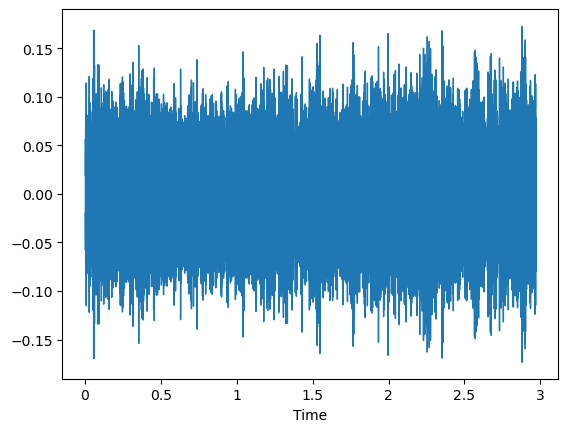

In [15]:
# sample-1 waveplot
librosa.display.waveshow(y) # waveplot gibt es nicht mehr obwohl selbe librose version warum?

In [16]:
# sample-1: audio
import IPython.display as ipd
ipd.Audio(sample1)

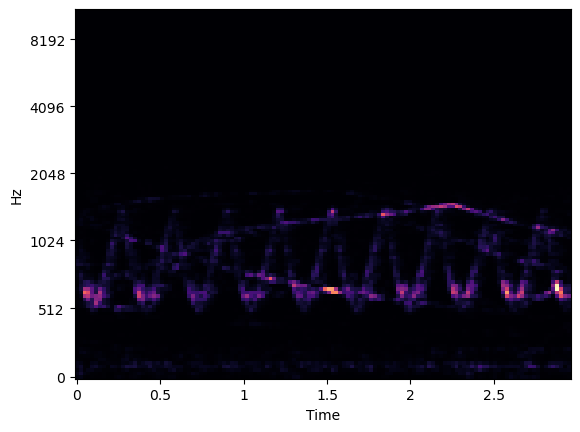

In [17]:
# sample-1: spectrogram
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [18]:
# street_music
train_input[train_input['Class']=='street_music'].head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,Class
8046,77901-9-0-3.wav,77901,1.500000,5.500000,1,10,9,street_music
8665,99157-9-0-16.wav,99157,12.928661,16.928661,2,4,9,street_music
6481,44325-9-0-72.wav,44325,36.000000,40.000000,2,6,9,street_music
3049,164377-9-1-43.wav,164377,208.038800,212.038800,1,10,9,street_music
6391,41364-9-0-22.wav,41364,11.000000,15.000000,1,8,9,street_music
7000,60605-9-0-90.wav,60605,45.000000,49.000000,1,2,9,street_music
1292,132016-9-0-6.wav,132016,49.661108,53.661108,2,1,9,street_music
6357,39967-9-0-99.wav,39967,68.803455,72.803455,1,8,9,street_music
3315,16860-9-0-26.wav,16860,14.989099,18.989099,1,8,9,street_music
8020,77766-9-0-4.wav,77766,2.000000,6.000000,1,1,9,street_music


In [19]:
# sample-2 load -> STREET_MUSIC
sample2_name = '77766-9-0-4.wav'
sample2 = AUDIO_DIR + '/fold' + str(train_input.loc[train_input['slice_file_name']==sample2_name, 'fold'].iloc[0]) + '/' + str(train_input.loc[train_input['slice_file_name']==sample2_name, 'slice_file_name'].iloc[0])
print(sample2)
duration = 2.97
sr = 22050

y2, sr2 = librosa.load(sample2, duration=duration, sr=sr)
ps2 = librosa.feature.melspectrogram(y=y2, sr=sr2)

input_length = sr * duration
offset = len(y2) - round(input_length)
print('input:', round(input_length), ' load:', len(y2), ' offset:', offset)
print('y shape:', y.shape, ' melspec shape:', ps.shape)

data/audio/fold1/77766-9-0-4.wav
input: 65489  load: 65489  offset: 0
y shape: (65489,)  melspec shape: (128, 128)


In [20]:
# sample-2: audio
import IPython.display as ipd
ipd.Audio(sample2)

(128, 128)

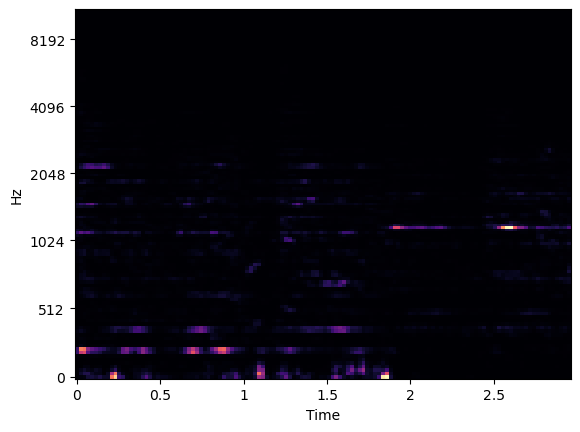

In [21]:
# sample-2: spectrogram
librosa.display.specshow(ps2, y_axis='mel', x_axis='time')
ps.shape

### Prepare data file loading

In [22]:
valid_train_data['path'] = AUDIO_DIR + '/fold' + valid_train_data['fold'].astype(str) + '/' + valid_train_data['slice_file_name'].astype(str)
print('sample', valid_train_data.iloc[0]['path'])
valid_train_data.head()

sample data/audio/fold2/203929-7-7-0.wav


,slice_file_name,fold,classID,Class,path
5353,203929-7-7-0.wav,2,7,jackhammer,data/audio/fold2/203929-7-7-0.wav
3772,176787-5-0-14.wav,1,5,engine_idling,data/audio/fold1/176787-5-0-14.wav
1456,135527-6-7-0.wav,7,6,gun_shot,data/audio/fold7/135527-6-7-0.wav
8339,88569-2-0-14.wav,3,2,children_playing,data/audio/fold3/88569-2-0-14.wav
6818,55018-0-0-37.wav,4,0,air_conditioner,data/audio/fold4/55018-0-0-37.wav


In [23]:
# test audio files
valid_test_data['path'] = AUDIO_DIR + '/fold' + valid_test_data['fold'].astype(str) + '/' + valid_test_data['slice_file_name'].astype(str)
print('sample', valid_test_data.iloc[0]['path'])
valid_test_data.head()

sample data/audio/fold3/54898-8-0-2.wav


,slice_file_name,fold,classID,path
6770,54898-8-0-2.wav,3,8,data/audio/fold3/54898-8-0-2.wav
3534,172338-9-0-7.wav,4,9,data/audio/fold4/172338-9-0-7.wav
8556,95562-4-3-0.wav,3,4,data/audio/fold3/95562-4-3-0.wav
7870,75490-8-0-2.wav,6,8,data/audio/fold6/75490-8-0-2.wav
1226,128891-3-0-4.wav,6,3,data/audio/fold6/128891-3-0-4.wav


### Loading audio files and features

In [24]:
#
# set duration on audio loading to make audio content to ensure each training data have same size
# 
# for instance, 3 seconds audio will have 128*128 which will be use on this notebook
#
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

#fix the load audio file size
audio_play_duration=2.97

def load_audio_file(file_path, duration=2.97, sr=22050):
    #load 5 seconds audio file, default 22 KHz default sr=22050
    # sr=resample to 16 KHz = 11025
    # sr=resample to 11 KHz = 16000
    # To preserve the native sampling rate of the file, use sr=None
    input_length=sr*duration
    # Load an audio file as a floating point time series.
    # y : np.ndarray [shape=(n,) or (2, n)] - audio time series
    # sr : number > 0 [scalar] - sampling rate of y
    y, sr = librosa.load(file_path,sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)
    #pad output if audio file less than duration
    # Use edge-padding instead of zeros
    #librosa.util.fix_length(y, 10, mode='edge')
    
    # if (round(dur) < duration):
    #     offset = len(y) - round(input_length)
    #     print ("fixing audio length :", file_path)
    #     print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
    #     y = librosa.util.fix_length(y, size=round(input_length))
    
    if (round(dur) < duration):
        print ("fixing audio length :", file_path)
        y = librosa.util.fix_length(y, size=round(input_length))
        offset = len(y) - round(input_length)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
    # y = audio_norm(y)
    # using a pre-computed power spectrogram
    # Short-time Fourier transform (STFT)
    #D = np.abs(librosa.stft(y))**2
    #ps = librosa.feature.melspectrogram(S=D)    
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps

Load audio files

In [25]:
%%time
%%memit 
# Dataset
train_audio_data = [] 
train_object_file='saved_train_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(train_object_file):
    SKIP_AUDIO_RELOAD = False

#load training data
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TRAINING data from audio files")
else:
    print ("loading train audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_train_data.itertuples()):
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128): continue
        train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))
# this step took sometime to finish    5382
#peak memory: 1141.30 MiB, increment: 642.16 MiB
#CPU times: user 15min 41s, sys: 14min 57s, total: 30min 39s

loading train audio data, may take more than 15 minutes. please wait!


18it [00:00, 173.07it/s]

fixing audio length : data/audio/fold7/135527-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-21-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/155129-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/7066-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-5-0.wav
input: 65489  load: 65489  offset: 0


54it [00:00, 169.03it/s]

fixing audio length : data/audio/fold7/50629-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/34241-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/44278-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-3-0.wav
input: 65489  load: 65489  offset: 0


88it [00:00, 148.28it/s]

fixing audio length : data/audio/fold6/194753-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/203355-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/25038-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/174293-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43784-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/65472-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148827-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-3-0.wav
input: 65489  load: 65489  offset: 0


140it [00:00, 153.57it/s]

fixing audio length : data/audio/fold8/24728-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-10-0.wav
input: 65489  load: 65489  offset: 0


172it [00:01, 154.57it/s]

fixing audio length : data/audio/fold2/145608-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162431-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-6-0.wav
input: 65489  load: 65489  offset: 0


205it [00:01, 155.09it/s]

fixing audio length : data/audio/fold8/107090-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/99185-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/89679-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26255-3-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-7-0.wav
input: 65489  load: 65489  offset: 0


256it [00:01, 160.86it/s]

fixing audio length : data/audio/fold4/171305-7-20-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/184355-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-3-0.wav
input: 65489  load: 65489  offset: 0


290it [00:01, 161.76it/s]

fixing audio length : data/audio/fold3/188824-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/43787-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-3-0.wav
input: 65489  load: 65489  offset: 0


342it [00:02, 165.32it/s]

fixing audio length : data/audio/fold6/9032-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/167702-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-5-0.wav
input: 65489  load: 65489  offset: 0


361it [00:02, 170.09it/s]

fixing audio length : data/audio/fold1/76093-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/166101-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-5-0.wav
input: 65489  load: 65489  offset: 0


413it [00:02, 153.22it/s]

fixing audio length : data/audio/fold7/24965-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-6-0.wav
input: 65489  load: 65489  offset: 0


445it [00:02, 153.10it/s]

fixing audio length : data/audio/fold5/165774-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/89213-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/88121-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/179858-1-0-0.wav
input: 65489  load: 65489  offset: 0


496it [00:03, 162.90it/s]

fixing audio length : data/audio/fold5/196071-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/178115-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/94868-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/171464-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/54086-1-2-0.wav
input: 65489  load: 65489  offset: 0


531it [00:03, 165.64it/s]

fixing audio length : data/audio/fold10/200460-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-19-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-64-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/42324-4-1-0.wav
input: 65489  load: 65489  offset: 0


582it [00:03, 159.36it/s]

fixing audio length : data/audio/fold1/176638-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/160092-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-1-0.wav
input: 65489  load: 65489  offset: 0


614it [00:03, 158.38it/s]

fixing audio length : data/audio/fold3/34708-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-1-0.wav
input: 65489  load: 65489  offset: 0


648it [00:04, 160.62it/s]

fixing audio length : data/audio/fold1/43786-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/7061-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/161010-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/102104-3-0-0.wav
input: 65489  load: 65489  offset: 0


765it [00:04, 129.64it/s]

fixing audio length : data/audio/fold8/168037-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/159176-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/47926-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35296-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-1-0.wav
input: 65489  load: 65489  offset: 0


799it [00:05, 145.50it/s]

fixing audio length : data/audio/fold1/174290-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/156418-3-2-0.wav
input: 65489  load: 65489  offset: 0


852it [00:05, 161.97it/s]

fixing audio length : data/audio/fold4/85544-3-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/70098-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14524-1-0-0.wav
input: 65489  load: 65489  offset: 0


888it [00:05, 162.36it/s]

fixing audio length : data/audio/fold7/183894-1-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174290-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/107090-1-1-0.wav
input: 65489  load: 65489  offset: 0


923it [00:05, 166.15it/s]

fixing audio length : data/audio/fold1/143604-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/203128-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/85544-3-7-0.wav
input: 65489  load: 65489  offset: 0


975it [00:06, 168.80it/s]

fixing audio length : data/audio/fold8/103076-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/158607-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17486-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-6-0.wav
input: 65489  load: 65489  offset: 0


1009it [00:06, 163.65it/s]

fixing audio length : data/audio/fold2/34621-4-26-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/110134-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/162541-1-1-0.wav
input: 65489  load: 65489  offset: 0


1044it [00:06, 163.49it/s]

fixing audio length : data/audio/fold7/89209-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/33849-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/69598-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145612-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/71082-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/115537-3-0-0.wav
input: 65489  load: 65489  offset: 0


1079it [00:06, 165.70it/s]

fixing audio length : data/audio/fold5/84699-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-15-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/159706-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/44278-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-9-0.wav
input: 65489  load: 65489  offset: 0


1115it [00:07, 169.43it/s]

fixing audio length : data/audio/fold9/70098-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26177-1-1-0.wav
input: 65489  load: 65489  offset: 0


1149it [00:07, 165.02it/s]

fixing audio length : data/audio/fold4/35799-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71439-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162431-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-91-0.wav
input: 65489  load: 65489  offset: 0


1183it [00:07, 165.78it/s]

fixing audio length : data/audio/fold1/179867-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-62-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/113160-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-9-0.wav
input: 65489  load: 65489  offset: 0


1218it [00:07, 166.08it/s]

fixing audio length : data/audio/fold8/33340-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/24652-6-0-0.wav
input: 65489  load: 65489  offset: 0


1269it [00:08, 162.42it/s]

fixing audio length : data/audio/fold10/200460-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4201-3-2-0.wav
input: 65489  load: 65489  offset: 0


1320it [00:08, 164.40it/s]

fixing audio length : data/audio/fold10/34050-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/33849-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/162540-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/9032-3-0-0.wav
input: 65489  load: 65489  offset: 0


1356it [00:08, 169.99it/s]

fixing audio length : data/audio/fold5/19503-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/85362-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26177-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/97606-7-4-0.wav
input: 65489  load: 65489  offset: 0


1444it [00:09, 169.33it/s]

fixing audio length : data/audio/fold6/204919-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/170245-0-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/185436-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/39533-4-0-0.wav
input: 65489  load: 65489  offset: 0


1478it [00:09, 164.19it/s]

fixing audio length : data/audio/fold6/167701-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/103076-3-1-0.wav
input: 65489  load: 65489  offset: 0


1512it [00:09, 162.17it/s]

fixing audio length : data/audio/fold2/34621-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/44831-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145612-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/42371-3-0-0.wav
input: 65489  load: 65489  offset: 0


1548it [00:09, 166.25it/s]

fixing audio length : data/audio/fold4/135528-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/165775-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/182474-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-4-0.wav
input: 65489  load: 65489  offset: 0


1599it [00:10, 163.49it/s]

fixing audio length : data/audio/fold5/205874-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/26185-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/25037-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/23218-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/147317-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/47926-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159745-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/116163-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/116163-3-0-0.wav
input: 65489  load: 65489  offset: 0


1616it [00:10, 162.45it/s]

fixing audio length : data/audio/fold7/156091-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/160093-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-2-0.wav
input: 65489  load: 65489  offset: 0


1651it [00:10, 153.37it/s]

fixing audio length : data/audio/fold5/159754-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/189846-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/156194-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/133797-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-2-0.wav
input: 65489  load: 65489  offset: 0


1705it [00:10, 168.31it/s]

fixing audio length : data/audio/fold6/125574-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/169261-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/179860-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76090-6-1-0.wav
input: 65489  load: 65489  offset: 0


1741it [00:10, 168.57it/s]

fixing audio length : data/audio/fold5/43787-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4201-3-0-0.wav
input: 65489  load: 65489  offset: 0


1777it [00:11, 169.25it/s]

fixing audio length : data/audio/fold5/165774-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/73168-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-8-0.wav
input: 65489  load: 65489  offset: 0


1831it [00:11, 172.73it/s]

fixing audio length : data/audio/fold9/180029-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/179862-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-20-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/32417-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/7060-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/175842-1-0-0.wav
input: 65489  load: 65489  offset: 0


1868it [00:11, 177.87it/s]

fixing audio length : data/audio/fold4/344-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/25039-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/94868-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/175848-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/66587-3-3-0.wav
input: 65489  load: 65489  offset: 0


1922it [00:11, 171.41it/s]

fixing audio length : data/audio/fold9/145683-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/39532-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174276-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/29936-3-1-0.wav
input: 65489  load: 65489  offset: 0


1959it [00:12, 170.05it/s]

fixing audio length : data/audio/fold10/205013-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/208652-8-6-0.wav
input: 65489  load: 65489  offset: 0


1997it [00:12, 176.57it/s]

fixing audio length : data/audio/fold5/145611-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/185436-1-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-4-0.wav
input: 65489  load: 65489  offset: 0


2034it [00:12, 173.06it/s]

fixing audio length : data/audio/fold3/49809-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162434-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/344-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-5-0.wav
input: 65489  load: 65489  offset: 0


2088it [00:12, 171.17it/s]

fixing audio length : data/audio/fold6/135544-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/89212-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-1-0.wav
input: 65489  load: 65489  offset: 0


2124it [00:13, 169.94it/s]

fixing audio length : data/audio/fold8/189846-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/77246-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/174293-6-2-0.wav
input: 65489  load: 65489  offset: 0


2143it [00:13, 173.04it/s]

fixing audio length : data/audio/fold8/145206-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/29932-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/175843-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-6-0.wav
input: 65489  load: 65489  offset: 0


2198it [00:13, 172.48it/s]

fixing audio length : data/audio/fold9/145683-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/26185-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/85663-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/196064-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/175854-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-9-0.wav
input: 65489  load: 65489  offset: 0


2233it [00:13, 168.15it/s]

fixing audio length : data/audio/fold6/159702-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/144885-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162702-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/155313-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/207962-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/94868-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/7063-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7062-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/155130-1-0-0.wav
input: 65489  load: 65489  offset: 0


2285it [00:14, 168.42it/s]

fixing audio length : data/audio/fold10/157207-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/76093-6-1-0.wav
input: 65489  load: 65489  offset: 0


2322it [00:14, 172.34it/s]

fixing audio length : data/audio/fold6/43802-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/176638-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/50613-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/196086-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/81791-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/52357-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/7060-6-1-0.wav
input: 65489  load: 65489  offset: 0


2359it [00:14, 174.53it/s]

fixing audio length : data/audio/fold4/176003-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/128030-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/155283-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/77247-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4911-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/118070-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-7-0.wav
input: 65489  load: 65489  offset: 0


2395it [00:14, 174.78it/s]

fixing audio length : data/audio/fold1/197073-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/25038-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/150341-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/159710-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-74-0.wav
input: 65489  load: 65489  offset: 0


2431it [00:14, 176.32it/s]

fixing audio length : data/audio/fold8/107190-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/94401-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-51-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/52171-3-2-0.wav
input: 65489  load: 65489  offset: 0


2468it [00:15, 173.48it/s]

fixing audio length : data/audio/fold5/162432-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/179863-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/77509-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174276-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-2-0.wav
input: 65489  load: 65489  offset: 0


2504it [00:15, 168.76it/s]

fixing audio length : data/audio/fold5/19503-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-1-0.wav
input: 65489  load: 65489  offset: 0


2538it [00:15, 167.45it/s]

fixing audio length : data/audio/fold3/135526-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/52284-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/200161-3-7-0.wav
input: 65489  load: 65489  offset: 0


2572it [00:15, 142.48it/s]

fixing audio length : data/audio/fold6/135544-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35296-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-1-0.wav
input: 65489  load: 65489  offset: 0


2606it [00:15, 153.49it/s]

fixing audio length : data/audio/fold9/178118-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/37869-3-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/47926-3-1-0.wav
input: 65489  load: 65489  offset: 0


2643it [00:16, 166.94it/s]

fixing audio length : data/audio/fold4/30832-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/108187-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/33849-3-0-0.wav
input: 65489  load: 65489  offset: 0


2696it [00:16, 162.43it/s]

fixing audio length : data/audio/fold6/167701-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-0-0.wav
input: 65489  load: 65489  offset: 0


2731it [00:16, 164.97it/s]

fixing audio length : data/audio/fold8/26176-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156362-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/37236-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/64346-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/191449-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148827-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-77-0.wav
input: 65489  load: 65489  offset: 0


2767it [00:16, 168.17it/s]

fixing audio length : data/audio/fold8/168037-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/116163-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/133797-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/152588-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-40-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26184-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/76094-6-0-0.wav
input: 65489  load: 65489  offset: 0


2803it [00:17, 167.95it/s]

fixing audio length : data/audio/fold1/87275-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/164312-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/36902-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/26186-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/180132-4-2-0.wav
input: 65489  load: 65489  offset: 0


2854it [00:17, 165.72it/s]

fixing audio length : data/audio/fold5/162432-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/108187-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/85661-3-0-0.wav
input: 65489  load: 65489  offset: 0


2888it [00:17, 163.28it/s]

fixing audio length : data/audio/fold8/33340-7-15-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/139948-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71439-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/189846-3-0-0.wav
input: 65489  load: 65489  offset: 0


2922it [00:17, 163.49it/s]

fixing audio length : data/audio/fold7/207962-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/180126-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/179861-1-0-0.wav
input: 65489  load: 65489  offset: 0


2973it [00:18, 163.01it/s]

fixing audio length : data/audio/fold1/197318-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159707-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/174287-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/58202-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/197243-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/51022-3-13-0.wav
input: 65489  load: 65489  offset: 0


3007it [00:18, 163.22it/s]

fixing audio length : data/audio/fold4/135528-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197073-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26255-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/61077-3-0-0.wav
input: 65489  load: 65489  offset: 0


3043it [00:18, 168.28it/s]

fixing audio length : data/audio/fold6/135544-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/94710-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/71080-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/183894-1-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/19338-5-3-0.wav
input: 65489  load: 65489  offset: 0


3077it [00:18, 168.59it/s]

fixing audio length : data/audio/fold3/90846-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-2-0.wav
input: 65489  load: 65489  offset: 0


3130it [00:19, 171.59it/s]

fixing audio length : data/audio/fold8/162433-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/162728-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/36403-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/178118-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/175855-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/142641-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-0-0.wav
input: 65489  load: 65489  offset: 0


3166it [00:19, 169.13it/s]

fixing audio length : data/audio/fold1/197318-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/9032-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-28-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43784-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/136399-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-0-0.wav
input: 65489  load: 65489  offset: 0


3235it [00:19, 168.09it/s]

fixing audio length : data/audio/fold7/83488-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/201207-3-13-0.wav
input: 65489  load: 65489  offset: 0


3271it [00:19, 166.48it/s]

fixing audio length : data/audio/fold9/155130-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/33641-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/166268-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/21187-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148828-6-1-0.wav
input: 65489  load: 65489  offset: 0


3306it [00:20, 166.31it/s]

fixing audio length : data/audio/fold7/148827-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/164625-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/23161-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-25-0.wav
input: 65489  load: 65489  offset: 0


3343it [00:20, 165.92it/s]

fixing audio length : data/audio/fold8/175856-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/144028-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-7-0.wav
input: 65489  load: 65489  offset: 0


3377it [00:20, 160.81it/s]

fixing audio length : data/audio/fold3/162431-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/187920-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/175845-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/54086-1-0-0.wav
input: 65489  load: 65489  offset: 0


3411it [00:20, 154.20it/s]

fixing audio length : data/audio/fold4/171249-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/148837-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/102106-3-0-0.wav
input: 65489  load: 65489  offset: 0


3464it [00:21, 164.90it/s]

fixing audio length : data/audio/fold4/165785-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/161010-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/118961-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/157799-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148827-6-3-0.wav
input: 65489  load: 65489  offset: 0


3498it [00:21, 162.77it/s]

fixing audio length : data/audio/fold2/34621-4-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-14-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/50668-5-1-0.wav
input: 65489  load: 65489  offset: 0


3533it [00:21, 163.12it/s]

fixing audio length : data/audio/fold7/183894-1-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/34050-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145609-6-1-0.wav
input: 65489  load: 65489  offset: 0


3568it [00:21, 164.54it/s]

fixing audio length : data/audio/fold10/17124-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-28-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/174290-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-3-0.wav
input: 65489  load: 65489  offset: 0


3606it [00:22, 166.83it/s]

fixing audio length : data/audio/fold3/176631-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/9031-3-1-0.wav
input: 65489  load: 65489  offset: 0


3658it [00:22, 167.55it/s]

fixing audio length : data/audio/fold4/47926-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/204919-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/149177-6-0-0.wav
input: 65489  load: 65489  offset: 0


3694it [00:22, 171.04it/s]

fixing audio length : data/audio/fold9/39532-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/72567-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/68389-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/83465-1-0-0.wav
input: 65489  load: 65489  offset: 0


3730it [00:22, 173.75it/s]

fixing audio length : data/audio/fold9/70098-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/17913-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/196078-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/133797-6-0-0.wav
input: 65489  load: 65489  offset: 0


3766it [00:22, 169.19it/s]

fixing audio length : data/audio/fold1/165645-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/151065-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/94020-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/118962-3-0-0.wav
input: 65489  load: 65489  offset: 0


3800it [00:23, 165.78it/s]

fixing audio length : data/audio/fold4/22883-7-71-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148827-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-2-0.wav
input: 65489  load: 65489  offset: 0


3834it [00:23, 164.30it/s]

fixing audio length : data/audio/fold6/148835-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/14468-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/83488-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145608-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/107842-4-1-0.wav
input: 65489  load: 65489  offset: 0


3886it [00:23, 164.37it/s]

fixing audio length : data/audio/fold3/118496-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-6-0.wav
input: 65489  load: 65489  offset: 0


3921it [00:23, 163.65it/s]

fixing audio length : data/audio/fold5/71439-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-27-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17486-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/103199-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/86284-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17486-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/66587-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-3-0.wav
input: 65489  load: 65489  offset: 0


3976it [00:24, 171.81it/s]

fixing audio length : data/audio/fold7/135527-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/118964-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/54858-3-2-0.wav
input: 65489  load: 65489  offset: 0


4011it [00:24, 164.28it/s]

fixing audio length : data/audio/fold3/148838-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-81-0.wav
input: 65489  load: 65489  offset: 0


4064it [00:24, 167.49it/s]

fixing audio length : data/audio/fold5/84699-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/68389-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148835-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/170243-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159705-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/158978-6-0-0.wav
input: 65489  load: 65489  offset: 0


4099it [00:25, 166.93it/s]

fixing audio length : data/audio/fold10/7965-3-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/4201-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/84317-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/166268-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-0-0.wav
input: 65489  load: 65489  offset: 0


4136it [00:25, 172.84it/s]

fixing audio length : data/audio/fold2/34621-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/119420-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/17810-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/166268-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/167750-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26173-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-3-0.wav
input: 65489  load: 65489  offset: 0


4173it [00:25, 171.47it/s]

fixing audio length : data/audio/fold4/171249-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/35629-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-15-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-5-0.wav
input: 65489  load: 65489  offset: 0


4226it [00:25, 168.91it/s]

fixing audio length : data/audio/fold2/175844-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/194753-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/203516-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/190680-3-1-0.wav
input: 65489  load: 65489  offset: 0


4277it [00:26, 164.21it/s]

fixing audio length : data/audio/fold1/43786-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/171464-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/103199-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/178260-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-0-0.wav
input: 65489  load: 65489  offset: 0


4312it [00:26, 167.12it/s]

fixing audio length : data/audio/fold5/164667-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/204919-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/143115-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/115535-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-27-0.wav
input: 65489  load: 65489  offset: 0


4347it [00:26, 165.32it/s]

fixing audio length : data/audio/fold8/71309-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/147672-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-18-0.wav
input: 65489  load: 65489  offset: 0


4398it [00:26, 162.80it/s]

fixing audio length : data/audio/fold9/72723-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159703-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/95562-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/164627-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159748-8-1-0.wav
input: 65489  load: 65489  offset: 0


4416it [00:26, 166.61it/s]

fixing audio length : data/audio/fold5/121299-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/4918-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/156200-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157800-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/24632-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/344-3-5-0.wav
input: 65489  load: 65489  offset: 0


4470it [00:27, 164.68it/s]

fixing audio length : data/audio/fold2/158607-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/43802-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/175856-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/148838-6-2-0.wav
input: 65489  load: 65489  offset: 0


4504it [00:27, 163.50it/s]

fixing audio length : data/audio/fold2/4201-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/187356-1-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-8-0.wav
input: 65489  load: 65489  offset: 0


4538it [00:27, 164.63it/s]

fixing audio length : data/audio/fold8/196074-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/33641-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/118496-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/156868-8-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/59800-3-2-0.wav
input: 65489  load: 65489  offset: 0


4572it [00:27, 163.05it/s]

fixing audio length : data/audio/fold2/132073-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/57553-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/18933-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/127872-0-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-5-0.wav
input: 65489  load: 65489  offset: 0


4628it [00:28, 173.99it/s]

fixing audio length : data/audio/fold8/24728-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/46655-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/187356-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/159752-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/148837-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/44831-3-2-0.wav
input: 65489  load: 65489  offset: 0


4668it [00:28, 180.43it/s]

fixing audio length : data/audio/fold8/155283-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/179864-1-0-0.wav
input: 65489  load: 65489  offset: 0


4723it [00:28, 168.27it/s]

fixing audio length : data/audio/fold2/113785-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/36902-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159702-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/165785-4-4-0.wav
input: 65489  load: 65489  offset: 0


4777it [00:29, 166.65it/s]

fixing audio length : data/audio/fold5/185436-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/164312-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-4-0.wav
input: 65489  load: 65489  offset: 0


4812it [00:29, 165.34it/s]

fixing audio length : data/audio/fold2/76091-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148833-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/203355-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-1-0.wav
input: 65489  load: 65489  offset: 0


4846it [00:29, 161.54it/s]

fixing audio length : data/audio/fold2/179866-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/71309-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/145683-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/100648-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/49809-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/19026-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/23131-3-0-0.wav
input: 65489  load: 65489  offset: 0


4901it [00:29, 169.96it/s]

fixing audio length : data/audio/fold4/68389-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/50668-5-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/17913-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159754-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/12647-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/196088-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-10-0.wav
input: 65489  load: 65489  offset: 0


4937it [00:30, 165.36it/s]

fixing audio length : data/audio/fold9/180029-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/175852-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-29-0.wav
input: 65489  load: 65489  offset: 0


5023it [00:30, 160.46it/s]

fixing audio length : data/audio/fold4/22883-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/17074-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/29932-1-1-0.wav
input: 65489  load: 65489  offset: 0


5058it [00:30, 166.63it/s]

fixing audio length : data/audio/fold10/209672-3-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24965-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/57607-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/70740-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/161010-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/25037-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71171-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/50618-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-2-0.wav
input: 65489  load: 65489  offset: 0


5094it [00:30, 168.70it/s]

fixing audio length : data/audio/fold6/71088-4-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/108187-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/125520-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/201207-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/179725-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/118072-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-72-0.wav
input: 65489  load: 65489  offset: 0


5131it [00:31, 169.90it/s]

fixing audio length : data/audio/fold5/43787-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/50612-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/162541-1-0-0.wav
input: 65489  load: 65489  offset: 0


5165it [00:31, 153.00it/s]

fixing audio length : data/audio/fold5/71439-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145612-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/85664-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/110389-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/170015-3-0-0.wav
input: 65489  load: 65489  offset: 0


5199it [00:31, 158.79it/s]

fixing audio length : data/audio/fold3/69598-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/57553-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/178118-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/89211-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/162148-3-0-0.wav
input: 65489  load: 65489  offset: 0


5255it [00:31, 176.78it/s]

fixing audio length : data/audio/fold5/165774-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/185800-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148834-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/209672-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/50614-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/88466-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-12-0.wav
input: 65489  load: 65489  offset: 0


5291it [00:32, 164.92it/s]

fixing audio length : data/audio/fold10/209672-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/176634-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/208652-8-2-0.wav
input: 65489  load: 65489  offset: 0


5328it [00:32, 172.80it/s]

fixing audio length : data/audio/fold6/71079-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/57553-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/11722-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-18-0.wav
input: 65489  load: 65489  offset: 0


5365it [00:32, 174.54it/s]

fixing audio length : data/audio/fold9/39532-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26184-5-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/148841-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/121888-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-48-0.wav
input: 65489  load: 65489  offset: 0


5419it [00:32, 170.72it/s]

fixing audio length : data/audio/fold9/159726-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162436-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/148833-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/158607-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-8-0.wav
input: 65489  load: 65489  offset: 0


5434it [00:32, 164.68it/s]

fixing audio length : data/audio/fold5/37869-3-3-0.wav
input: 65489  load: 65489  offset: 0
Number of train samples:  5375
peak memory: 551.80 MiB, increment: 2.45 MiB
CPU times: user 47 s, sys: 1.95 s, total: 49 s
Wall time: 33.5 s


In [26]:
# load saved audio object
if SKIP_AUDIO_RELOAD is True:
    train_audio_data = cPickle.load(open(train_object_file, 'rb'))
    print ("loaded train data [%s] records from object file" % len(train_audio_data))  
else:
    cPickle.dump(train_audio_data, open(train_object_file, 'wb')) 
    print ("saved loaded train data :",len(train_audio_data))

saved loaded train data : 5375


In [27]:
%%time
%%memit 
#load test data
test_audio_data = []
test_object_file='saved_test_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(test_object_file):
    SKIP_AUDIO_RELOAD = False

if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TEST data from audio files")
else:
    print ("loading test audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_test_data.itertuples()):  # valid_test_data zu 
        ps = load_audio_file(file_path=row.path, duration=2.97)
        if ps.shape != (128, 128):
            print ("***data shape is wrong, replace it with zeros ", ps.shape, row.path)
            ps = np.zeros([128, 128])
            #continue
        test_audio_data.append( (ps, row.classID) ) 
    print("Number of test samples: ", len(test_audio_data))
    
# this step took sometime to finish    3251
#peak memory: 1586.96 MiB, increment: 445.65 MiB
#CPU times: user 9min 32s, sys: 9min 37s, total: 19min 10s 

loading test audio data, may take more than 15 minutes. please wait!


17it [00:00, 166.42it/s]

fixing audio length : data/audio/fold10/146244-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46654-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/183894-1-5-0.wav
input: 65489  load: 65489  offset: 0


35it [00:00, 172.43it/s]

***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold2/197320-6-12-0.wav


53it [00:00, 170.08it/s]

fixing audio length : data/audio/fold5/43803-1-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold8/167702-4-9-0.wav
fixing audio length : data/audio/fold3/135526-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/187356-1-1-0.wav
input: 65489  load: 65489  offset: 0


71it [00:00, 168.97it/s]

fixing audio length : data/audio/fold8/168037-4-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/147672-3-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 114) data/audio/fold2/197320-6-10-0.wav


88it [00:00, 164.77it/s]

fixing audio length : data/audio/fold6/162702-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/140824-4-0-0.wav
input: 65489  load: 65489  offset: 0


137it [00:00, 154.53it/s]

fixing audio length : data/audio/fold2/34621-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/14115-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/96158-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-33-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/51022-3-29-0.wav
input: 65489  load: 65489  offset: 0


167it [00:01, 130.61it/s]

fixing audio length : data/audio/fold5/185436-1-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/106955-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/9031-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71086-4-2-0.wav
input: 65489  load: 65489  offset: 0


195it [00:01, 131.95it/s]

fixing audio length : data/audio/fold10/34050-7-5-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold5/196081-2-0-0.wav
fixing audio length : data/audio/fold6/135544-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/39533-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/7068-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/44110-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/164312-3-4-0.wav
input: 65489  load: 65489  offset: 0


223it [00:01, 130.61it/s]

fixing audio length : data/audio/fold4/135528-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-3-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold1/155310-3-0-0.wav
fixing audio length : data/audio/fold3/12647-3-2-0.wav
input: 65489  load: 65489  offset: 0


253it [00:01, 136.05it/s]

fixing audio length : data/audio/fold5/197243-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/207369-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-9-0.wav
input: 65489  load: 65489  offset: 0


284it [00:01, 141.94it/s]

fixing audio length : data/audio/fold7/97606-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/162134-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/42324-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/163459-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-69-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 110) data/audio/fold9/70098-3-1-0.wav
fixing audio length : data/audio/fold9/16772-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-5-0.wav
input: 65489  load: 65489  offset: 0


320it [00:02, 156.88it/s]

fixing audio length : data/audio/fold1/87275-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/23131-3-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/2937-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/37869-3-0-0.wav
input: 65489  load: 65489  offset: 0


370it [00:02, 155.16it/s]

fixing audio length : data/audio/fold1/162703-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-24-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/151877-5-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/34643-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/155234-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/203128-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-3-0.wav
input: 65489  load: 65489  offset: 0


402it [00:02, 153.67it/s]

fixing audio length : data/audio/fold1/197318-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/113203-5-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/186938-5-0-0.wav
input: 65489  load: 65489  offset: 0


435it [00:02, 156.16it/s]

fixing audio length : data/audio/fold4/7064-6-1-0.wav
input: 65489  load: 65489  offset: 0


468it [00:03, 150.73it/s]

fixing audio length : data/audio/fold5/205874-4-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/196060-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/86278-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/162431-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-3-0.wav
input: 65489  load: 65489  offset: 0


531it [00:03, 148.86it/s]

fixing audio length : data/audio/fold3/188824-7-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/31840-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/151069-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-6-0.wav
input: 65489  load: 65489  offset: 0


563it [00:03, 153.86it/s]

***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold8/49974-1-0-0.wav
fixing audio length : data/audio/fold3/188824-7-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/73168-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/167750-4-2-0.wav
input: 65489  load: 65489  offset: 0


599it [00:03, 164.68it/s]

***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold3/69598-4-5-0.wav
fixing audio length : data/audio/fold5/46391-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/147764-4-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-93-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/188823-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-8-0.wav
input: 65489  load: 65489  offset: 0


634it [00:04, 165.29it/s]

***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold1/182800-2-1-0.wav
***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold6/71088-4-1-0.wav
fixing audio length : data/audio/fold10/85665-3-0-0.wav
input: 65489  load: 65489  offset: 0


670it [00:04, 171.07it/s]

***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold7/99812-1-5-0.wav
fixing audio length : data/audio/fold3/82811-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-11-0.wav
input: 65489  load: 65489  offset: 0


726it [00:04, 175.02it/s]

***data shape is wrong, replace it with zeros  (128, 121) data/audio/fold9/152588-3-3-0.wav
fixing audio length : data/audio/fold9/180156-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/102103-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/155309-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/158979-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/93139-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/39857-5-2-0.wav
input: 65489  load: 65489  offset: 0


781it [00:05, 164.11it/s]

fixing audio length : data/audio/fold1/162540-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/71082-4-1-0.wav
input: 65489  load: 65489  offset: 0


818it [00:05, 169.11it/s]

fixing audio length : data/audio/fold4/35296-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/4918-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/38231-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/155129-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/7064-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/209672-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/69598-4-4-0.wav
input: 65489  load: 65489  offset: 0


871it [00:05, 166.61it/s]

fixing audio length : data/audio/fold5/84699-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-9-0.wav
input: 65489  load: 65489  offset: 0


907it [00:05, 169.93it/s]

fixing audio length : data/audio/fold7/89679-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/117536-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84699-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/196062-2-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 110) data/audio/fold8/113203-5-2-0.wav
fixing audio length : data/audio/fold4/344-3-0-0.wav
input: 65489  load: 65489  offset: 0


942it [00:06, 165.38it/s]

fixing audio length : data/audio/fold8/162433-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/66587-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-34-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/99812-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/38231-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26177-1-2-0.wav
input: 65489  load: 65489  offset: 0


997it [00:06, 173.55it/s]

fixing audio length : data/audio/fold3/135526-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/100032-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76089-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-17-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 110) data/audio/fold1/98223-7-0-0.wav
fixing audio length : data/audio/fold4/171305-7-11-0.wav
input: 65489  load: 65489  offset: 0


1034it [00:06, 175.61it/s]

fixing audio length : data/audio/fold9/180156-1-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/132073-1-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/196080-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-17-0.wav
input: 65489  load: 65489  offset: 0


1070it [00:06, 169.27it/s]

fixing audio length : data/audio/fold2/23131-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/17810-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/23161-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-1-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 117) data/audio/fold7/57596-3-0-0.wav
fixing audio length : data/audio/fold9/39532-4-2-0.wav
input: 65489  load: 65489  offset: 0


1104it [00:06, 163.17it/s]

fixing audio length : data/audio/fold7/7060-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/178261-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/125554-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/24076-1-0-0.wav
input: 65489  load: 65489  offset: 0


1171it [00:07, 155.76it/s]

fixing audio length : data/audio/fold9/52171-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-12-0.wav
input: 65489  load: 65489  offset: 0


1206it [00:07, 163.82it/s]

fixing audio length : data/audio/fold1/87275-1-3-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 114) data/audio/fold4/38231-3-4-0.wav
fixing audio length : data/audio/fold5/162432-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/42101-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/167750-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/26184-5-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180029-4-5-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 116) data/audio/fold4/81068-5-2-0.wav
fixing audio length : data/audio/fold9/148166-6-0-0.wav
input: 65489  load: 65489  offset: 0


1243it [00:07, 171.69it/s]

fixing audio length : data/audio/fold6/43802-1-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold3/103199-4-4-0.wav
fixing audio length : data/audio/fold10/11722-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/103074-7-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/208030-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/89210-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/160094-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/84254-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-8-0.wav
input: 65489  load

1296it [00:08, 167.94it/s]

fixing audio length : data/audio/fold10/179868-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/97756-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/162432-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-63-0.wav
input: 65489  load: 65489  offset: 0


1330it [00:08, 165.29it/s]

fixing audio length : data/audio/fold9/175853-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162434-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/37869-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/159726-3-0-0.wav
input: 65489  load: 65489  offset: 0


1364it [00:08, 163.14it/s]

fixing audio length : data/audio/fold1/9031-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/98536-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/197318-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-22-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/71087-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-5-0.wav
input: 65489  load: 65489  offset: 0


1415it [00:08, 164.21it/s]

fixing audio length : data/audio/fold8/113203-5-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7965-3-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/20841-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/207962-3-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold3/135526-6-2-0.wav
fixing audio length : data/audio/fold4/30832-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135849-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151071-6-0-0.wav
input: 65489  load: 65489  offset: 0


1448it [00:09, 144.34it/s]

fixing audio length : data/audio/fold10/178402-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/204765-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/175846-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/162134-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-1-0.wav
input: 65489  load: 65489  offset: 0


1482it [00:09, 156.43it/s]

fixing audio length : data/audio/fold8/145612-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/51022-3-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/148837-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/24631-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/175856-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/17307-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/131199-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-3-0.wav
input: 65489  load: 65489  offset: 0


1518it [00:09, 165.03it/s]

***data shape is wrong, replace it with zeros  (128, 123) data/audio/fold2/197320-6-5-0.wav
fixing audio length : data/audio/fold3/128030-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/73168-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/207124-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/162434-6-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 126) data/audio/fold10/26344-4-0-0.wav
fixing audio length : data/audio/fold2/155129-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/24632-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-20-0.wav
input: 65489  load: 65489  offset: 0


1570it [00:09, 167.99it/s]

fixing audio length : data/audio/fold7/153057-1-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 115) data/audio/fold8/33340-7-2-0.wav
fixing audio length : data/audio/fold7/97606-7-5-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 127) data/audio/fold10/20571-3-0-0.wav
fixing audio length : data/audio/fold5/52102-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-14-0.wav
input: 65489  load: 65489  offset: 0


1604it [00:10, 162.45it/s]

fixing audio length : data/audio/fold6/143115-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/164626-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-7-0.wav
input: 65489  load: 65489  offset: 0


1655it [00:10, 160.99it/s]

fixing audio length : data/audio/fold8/189846-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/165774-7-4-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold1/102305-6-0-0.wav
fixing audio length : data/audio/fold3/135526-6-3-0.wav
input: 65489  load: 65489  offset: 0


1689it [00:10, 158.89it/s]

fixing audio length : data/audio/fold8/44110-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/66587-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/54086-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/167701-4-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/208652-8-4-0.wav
input: 65489  load: 65489  offset: 0


1738it [00:10, 157.94it/s]

fixing audio length : data/audio/fold5/43787-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/203128-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-7-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 123) data/audio/fold4/135528-6-3-0.wav


1791it [00:11, 168.84it/s]

fixing audio length : data/audio/fold6/167701-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/165775-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/148841-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/148841-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145577-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-1-0.wav
input: 65489  load: 65489  offset: 0


1826it [00:11, 168.73it/s]

fixing audio length : data/audio/fold8/4918-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/208030-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4910-3-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold7/99812-1-6-0.wav
fixing audio length : data/audio/fold4/171305-7-13-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/180960-6-0-0.wav
input: 65489  load: 65489  offset: 0


1863it [00:11, 167.94it/s]

fixing audio length : data/audio/fold6/159702-6-2-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 124) data/audio/fold1/174276-7-5-0.wav
fixing audio length : data/audio/fold9/98859-7-1-0.wav
input: 65489  load: 65489  offset: 0


1914it [00:11, 165.16it/s]

fixing audio length : data/audio/fold4/203956-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/73623-7-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/188824-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/68657-1-0-0.wav
input: 65489  load: 65489  offset: 0


1948it [00:12, 162.91it/s]

fixing audio length : data/audio/fold9/145683-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/146249-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/175847-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71171-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/113785-3-1-0.wav
input: 65489  load: 65489  offset: 0


1999it [00:12, 160.50it/s]

fixing audio length : data/audio/fold6/135544-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/179865-1-0-0.wav
input: 65489  load: 65489  offset: 0


2032it [00:12, 153.74it/s]

fixing audio length : data/audio/fold3/110622-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/208030-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-4-0.wav
input: 65489  load: 65489  offset: 0


2068it [00:12, 160.95it/s]

fixing audio length : data/audio/fold4/22883-7-92-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145608-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/71079-4-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 111) data/audio/fold2/156893-7-7-0.wav
fixing audio length : data/audio/fold7/77751-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/200460-6-4-0.wav
input: 65489  load: 65489  offset: 0


2104it [00:13, 164.99it/s]

fixing audio length : data/audio/fold2/108187-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/162541-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-25-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/164646-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/22347-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/12647-3-1-0.wav
input: 65489  load: 65489  offset: 0


2138it [00:13, 160.00it/s]

fixing audio length : data/audio/fold8/50668-5-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/24728-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145611-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/196076-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/23131-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/72265-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-8-0.wav
input: 65489  load: 65489  offset: 0


2206it [00:13, 160.09it/s]

fixing audio length : data/audio/fold8/29936-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/175849-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/118963-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/158977-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159754-8-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/159708-6-3-0.wav
input: 65489  load: 65489  offset: 0


2240it [00:13, 160.60it/s]

fixing audio length : data/audio/fold1/9031-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/175850-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/162435-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-13-0.wav
input: 65489  load: 65489  offset: 0


2274it [00:14, 159.01it/s]

fixing audio length : data/audio/fold4/199929-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/159704-6-0-0.wav
input: 65489  load: 65489  offset: 0


2309it [00:14, 165.11it/s]

fixing audio length : data/audio/fold8/167702-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/61077-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/159701-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/45256-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/111048-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/174289-6-0-0.wav
input: 65489  load: 65489  offset: 0


2360it [00:14, 165.98it/s]

fixing audio length : data/audio/fold1/196079-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-2-0.wav
input: 65489  load: 65489  offset: 0


2395it [00:14, 168.16it/s]

fixing audio length : data/audio/fold8/125520-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171249-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/34050-7-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/155320-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/174841-1-0-0.wav
input: 65489  load: 65489  offset: 0


2430it [00:15, 162.22it/s]

fixing audio length : data/audio/fold2/71080-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/18453-3-0-0.wav
input: 65489  load: 65489  offset: 0


2464it [00:15, 160.11it/s]

fixing audio length : data/audio/fold4/7064-6-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/161010-1-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-17-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/87275-1-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/159709-6-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold3/33696-3-0-0.wav


2500it [00:15, 165.91it/s]

fixing audio length : data/audio/fold2/34621-4-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/145206-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/180156-1-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/165567-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-23-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-18-0.wav
input: 65489  load: 65489  offset: 0


2534it [00:15, 160.85it/s]

fixing audio length : data/audio/fold1/197318-6-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/33641-3-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/135527-6-10-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/30832-3-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/161195-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/49769-5-1-0.wav
input: 65489  load: 65489  offset: 0


2587it [00:16, 163.52it/s]

fixing audio length : data/audio/fold7/159708-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/34241-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7965-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/171305-7-14-0.wav
input: 65489  load: 65489  offset: 0


2621it [00:16, 160.84it/s]

fixing audio length : data/audio/fold1/197318-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/98223-7-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/109711-3-1-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 109) data/audio/fold10/162134-7-4-0.wav
fixing audio length : data/audio/fold7/14772-7-8-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold4/187356-1-5-0.wav
fixing audio length : data/audio/fold5/139948-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/162433-6-2-0.wav
input: 65489  load: 65489  offset: 0


2672it [00:16, 163.63it/s]

fixing audio length : data/audio/fold4/22883-7-86-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 113) data/audio/fold9/174282-6-1-0.wav
fixing audio length : data/audio/fold8/168037-4-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/168037-4-2-0.wav
input: 65489  load: 65489  offset: 0


2707it [00:16, 166.75it/s]

fixing audio length : data/audio/fold4/196061-2-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/43805-8-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/14772-7-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/25039-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/174293-6-0-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 117) data/audio/fold2/197320-6-6-0.wav


2741it [00:17, 162.37it/s]

fixing audio length : data/audio/fold7/157950-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/118440-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/165645-4-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/135526-6-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/162540-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/135544-6-11-0.wav
input: 65489  load: 65489  offset: 0


2775it [00:17, 159.87it/s]

fixing audio length : data/audio/fold3/128030-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/175851-1-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/18594-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/7913-3-3-0.wav
input: 65489  load: 65489  offset: 0


2809it [00:17, 159.90it/s]

fixing audio length : data/audio/fold4/22883-7-37-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/181624-4-9-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 125) data/audio/fold10/174292-6-1-0.wav


2844it [00:17, 164.32it/s]

***data shape is wrong, replace it with zeros  (128, 112) data/audio/fold9/174282-6-0-0.wav
fixing audio length : data/audio/fold4/171305-7-21-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 118) data/audio/fold7/7067-6-0-0.wav
fixing audio length : data/audio/fold3/135526-6-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/6984-1-0-0.wav
input: 65489  load: 65489  offset: 0


2897it [00:18, 169.70it/s]

fixing audio length : data/audio/fold10/188813-7-12-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/4918-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/127873-0-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/188813-7-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/76094-6-1-0.wav
input: 65489  load: 65489  offset: 0


2931it [00:18, 167.17it/s]

fixing audio length : data/audio/fold7/34871-3-11-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/33340-7-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/163460-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/57323-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/34708-6-5-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/71086-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/145608-6-1-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 116) data/audio/fold5/185436-1-3-0.wav
fixing audio length : data/audio/fold2/33849-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/4912-3-0-0.wav
input: 65489  load: 65489  offset: 0


2982it [00:18, 162.27it/s]

fixing audio length : data/audio/fold3/148838-6-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/165567-3-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/203128-3-9-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/197320-6-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-8-0.wav
input: 65489  load: 65489  offset: 0


3016it [00:18, 162.14it/s]

fixing audio length : data/audio/fold1/165645-4-3-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 117) data/audio/fold4/171305-7-0-0.wav
fixing audio length : data/audio/fold6/135544-6-16-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold9/152588-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/150341-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/85362-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76091-6-0-0.wav
input: 65489  load: 65489  offset: 0


3050it [00:18, 162.80it/s]

***data shape is wrong, replace it with zeros  (128, 116) data/audio/fold8/155294-3-0-0.wav
fixing audio length : data/audio/fold8/89207-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold3/151359-1-3-0.wav
input: 65489  load: 65489  offset: 0


3083it [00:19, 158.81it/s]

fixing audio length : data/audio/fold9/33641-3-8-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/205874-4-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/102103-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/156893-7-5-0.wav
input: 65489  load: 65489  offset: 0


3133it [00:19, 161.73it/s]

fixing audio length : data/audio/fold2/132073-1-3-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/88121-8-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/148828-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/147672-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/115411-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/34621-4-15-0.wav
input: 65489  load: 65489  offset: 0


3184it [00:19, 162.62it/s]

fixing audio length : data/audio/fold6/135544-6-19-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/135528-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/131571-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/179866-1-1-0.wav
input: 65489  load: 65489  offset: 0


3219it [00:19, 166.06it/s]

fixing audio length : data/audio/fold6/28284-3-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/145609-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/76090-6-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold7/85662-3-0-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold2/77751-4-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/157207-6-7-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/107842-4-3-0.wav
input: 65489  load: 65489  offset: 0
***data shape is wrong, replace it with zeros  (128, 120) data/audio/fold7/97606-7-1-0.wav


3253it [00:20, 163.72it/s]

fixing audio length : data/audio/fold3/18594-1-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold4/22883-7-67-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold10/26255-3-6-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/96159-4-1-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold1/46656-6-3-0.wav
input: 65489  load: 65489  offset: 0


3298it [00:20, 160.99it/s]


fixing audio length : data/audio/fold4/22883-7-100-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold8/29936-3-2-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold6/160575-3-4-0.wav
input: 65489  load: 65489  offset: 0
fixing audio length : data/audio/fold5/20285-3-2-0.wav
input: 65489  load: 65489  offset: 0
Number of test samples:  3298
peak memory: 863.91 MiB, increment: 4.83 MiB
CPU times: user 29.1 s, sys: 1.51 s, total: 30.6 s
Wall time: 21.3 s


In [28]:
# load saved data
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 3298


### Prepare data for training

Encode labels

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from numpy import argmax

# get a set of unique text labels
list_labels = sorted(list(set(valid_train_data.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(valid_train_data.path.values, valid_train_data.classID.values)}

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
#print ("test label to int ",label_to_int["Applause"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}


unique text labels count:  10
labels:  ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
encoded labelint values [0 1 2 3 4 5 6 7 8 9]


Split up data into train, test and validation

In [30]:
#full dataset
dataset = train_audio_data
random.shuffle(dataset)

RATIO=0.9
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (4838, 128, 128, 1) 4838
test  (537, 128, 128, 1) 537


In [31]:
# Apply sck-learn label text encoding to integer
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

In [32]:
# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

In [33]:
#split up test into test and validation 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.30, random_state=42)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))

test  (375, 128, 128, 1) 375
valid  (162, 128, 128, 1) 162


### Training

In [34]:
# build convolution model
# input shape = (128, 128, 1)
model = Sequential()
input_shape= X_train.shape[1:] 

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))  # wieso input_shape hier 124,124?
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))
model.summary()

# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model-aufbau.png', show_shapes=True, show_layer_names=True)

# model.save('model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 24)      624       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 62, 24)        0         
 D)                                                              
                                                                 
 activation (Activation)     (None, 31, 62, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 58, 48)        28848     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 29, 48)         0         
 g2D)                                                            
                                                                 
 activation_1 (Activation)   (None, 6, 29, 48)         0

In [35]:
%%time
%%memit

# NOTE:
# Increase number if epochs from  1 to 60 or 100 for higher prediction accuracy
# default is set to 1 for faster commit 
MAX_EPOCHS=50
MAX_BATCH_SIZE=23            
# learning rate reduction rate 
MAX_PATIENT=2  

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

#train
print('training started.... please wait!')
history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose=0,
                    validation_data= (X_val, y_val), 
                    callbacks=callback)
print('training finished')

# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])

training started.... please wait!

Epoch 1: loss improved from inf to 2.56245, saving model to ./best_model_trained.hdf5

Epoch 2: loss improved from 2.56245 to 2.02410, saving model to ./best_model_trained.hdf5

Epoch 3: loss improved from 2.02410 to 1.79774, saving model to ./best_model_trained.hdf5

Epoch 4: loss improved from 1.79774 to 1.60487, saving model to ./best_model_trained.hdf5

Epoch 5: loss improved from 1.60487 to 1.53383, saving model to ./best_model_trained.hdf5

Epoch 6: loss improved from 1.53383 to 1.49309, saving model to ./best_model_trained.hdf5

Epoch 7: loss improved from 1.49309 to 1.38275, saving model to ./best_model_trained.hdf5

Epoch 8: loss improved from 1.38275 to 1.34393, saving model to ./best_model_trained.hdf5

Epoch 9: loss improved from 1.34393 to 1.22273, saving model to ./best_model_trained.hdf5

Epoch 10: loss improved from 1.22273 to 1.21817, saving model to ./best_model_trained.hdf5

Epoch 11: loss improved from 1.21817 to 1.18406, saving mo

<Figure size 2200x1000 with 0 Axes>

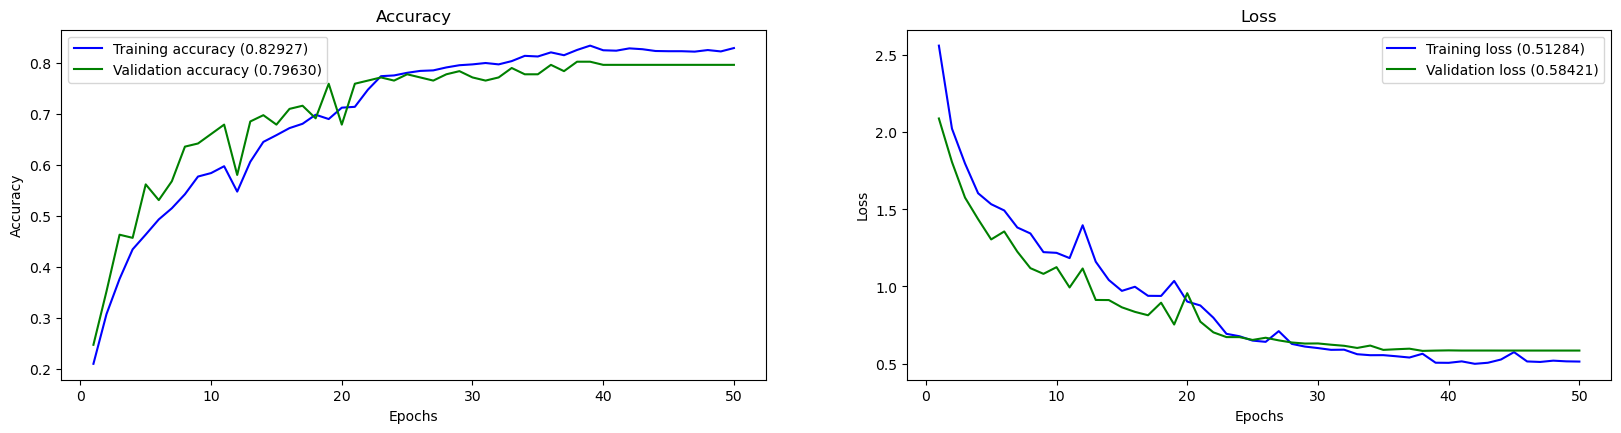

<Figure size 2200x1000 with 0 Axes>

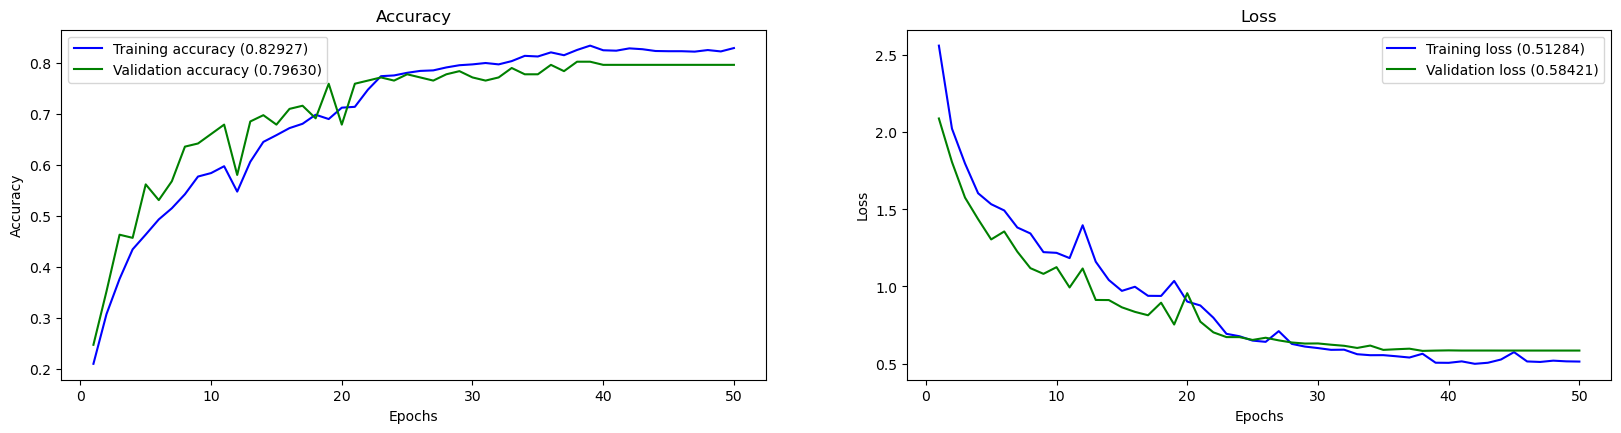

peak memory: 495.12 MiB, increment: 10.75 MiB
CPU times: user 367 ms, sys: 131 ms, total: 498 ms
Wall time: 1.49 s


In [36]:
%%time
%%memit

import matplotlib.pyplot as plt
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

Model Evaluation

In [37]:
#Evaludate model use Keras reported accuracy:
score = model.evaluate(X_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(X_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  88 %
model test data score        :  79 %
model validation data score  :  80 %


### Prediction Test

Train Split

In [38]:
print ("Prediction with [train] data")
# y_pred = model.predict_classes(X_train) -> gibts in Tensorflow 2.X nicht mehr (model.predict_classes)
probs   = model.predict(X_train)
y_pred  = np.argmax(probs, axis=1)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_train[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
# print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%") acc wurde im Original falsch berechnet
print ("  |__accuracy :", round(len(matched)/(len(matched) + len(missed))*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(5):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_train[i])])
    print ("")

Prediction with [train] data
152/152 [==============================] - 4s 25ms/step
  |__match    : 4278
  |__miss     : 560
  |__accuracy : 88.42 %

---samples---
0 predict = street_music
0 original= street_music

1 predict = air_conditioner
1 original= air_conditioner

2 predict = street_music
2 original= street_music

3 predict = dog_bark
3 original= dog_bark

4 predict = street_music
4 original= street_music



Test Split

In [39]:
# prediction class 
print ("Prediction with [test] data")
# y_pred = model.predict_classes(X_test) -> auch hier nicht in TF 2.X verfügbar
probs   = model.predict(X_test)
y_pred  = np.argmax(probs, axis=1)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_test[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
# print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")  auch hier acc falsch berechnet
print ("  |__accuracy :", round(len(matched)/(len(matched) + len(missed))*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(8):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_test[i])])
    print ("")

Prediction with [test] data
12/12 [==============================] - 0s 25ms/step
  |__match    : 295
  |__miss     : 80
  |__accuracy : 78.67 %

---samples---
0 predict = street_music
0 original= street_music

1 predict = gun_shot
1 original= drilling

2 predict = siren
2 original= siren

3 predict = dog_bark
3 original= dog_bark

4 predict = air_conditioner
4 original= air_conditioner

5 predict = children_playing
5 original= children_playing

6 predict = siren
6 original= siren

7 predict = engine_idling
7 original= engine_idling



Validation Split

In [40]:
# prediction class 
print ("Prediction with [validation] data")
# y_pred = model.predict_classes(X_val) -> auch hier TF 2.X 
probs   = model.predict(X_val)
y_pred  = np.argmax(probs, axis=1)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_val[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
# print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%") -> auch hier acc falsch
print ("  |__accuracy :", round(len(matched)/(len(matched) + len(missed))*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(8):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_val[i])])
    print ("")

Prediction with [validation] data
6/6 [==============================] - 0s 22ms/step
  |__match    : 129
  |__miss     : 33
  |__accuracy : 79.63 %

---samples---
0 predict = drilling
0 original= drilling

1 predict = dog_bark
1 original= dog_bark

2 predict = children_playing
2 original= dog_bark

3 predict = dog_bark
3 original= drilling

4 predict = drilling
4 original= drilling

5 predict = engine_idling
5 original= engine_idling

6 predict = street_music
6 original= street_music

7 predict = car_horn
7 original= car_horn



### Prepare Submission

In [41]:
print ("test data size ",len(test_audio_data))
sub_test = test_audio_data[1:22]
tx_test, ty_test = zip(*test_audio_data)

# make prediction 
tx_test2 = np.array([x.reshape((128, 128, 1)) for x in tx_test])
print ("test data shape ", tx_test2.shape)

test data size  3298
test data shape  (3298, 128, 128, 1)


In [42]:
# run prediction data
# y_pred = model.predict_classes(tx_test2, batch_size=1) -> auch hier TF 2.X Problematik
probs   = model.predict(tx_test2, batch_size=1)
y_pred  = np.argmax(probs, axis=1)
print ( len(y_pred), len(tx_test2))

3298/3298 [==============================] - 7s 2ms/step
3298 3298


In [43]:
# save result for submission
prediction_output_file='prediction_result_1.csv'
with open(prediction_output_file,"w") as file:
    file.write("ID,Prediction\n") 
    i=0
    for i in range( (len(valid_test_data)-1)) :
        #print(i, y_pred[i])
        file.write(str(valid_test_data.iloc[i]['classID'])+','+ int_to_label[y_pred[i]])    # mit iloc ansprechen anstatt am ende einfach []
        file.write('\n')
        i=i+1
        
print(len(y_pred))
output = pd.read_csv(prediction_output_file)
output.head(20)

3298


,ID,Prediction
0,8,jackhammer
1,9,street_music
2,4,dog_bark
3,8,siren
4,3,dog_bark
5,7,jackhammer
6,2,children_playing
7,2,dog_bark
8,4,drilling
9,3,dog_bark


### Klassenverteilung Plot

In [44]:
air_conditioner0 = len(input[input['classID']==0])
car_horn1 = len(input[input['classID']==1])
children_playing2 = len(input[input['classID']==2])
dog_bark3 = len(input[input['classID']==3])
drilling4 = len(input[input['classID']==4])
engine_idling5 = len(input[input['classID']==5])
gun_shot6 = len(input[input['classID']==6])
jackhammer7 = len(input[input['classID']==7])
siren8 = len(input[input['classID']==8])
street_music9 = len(input[input['classID']==9])


In [45]:
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'G

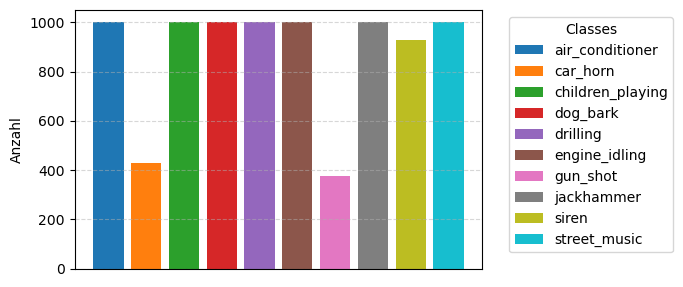

In [46]:
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
counts = [air_conditioner0, car_horn1, children_playing2, dog_bark3, drilling4, engine_idling5, gun_shot6, jackhammer7, siren8, street_music9]

import matplotlib.cm as cm

plt.figure(figsize=(7, 3))
colors = cm.get_cmap('tab10')(range(len(classes)))
bars = plt.bar(classes, counts, color=colors)

plt.xticks([])
plt.xlabel('')
plt.legend(bars, classes, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Anzahl')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Konfusionsmatrix

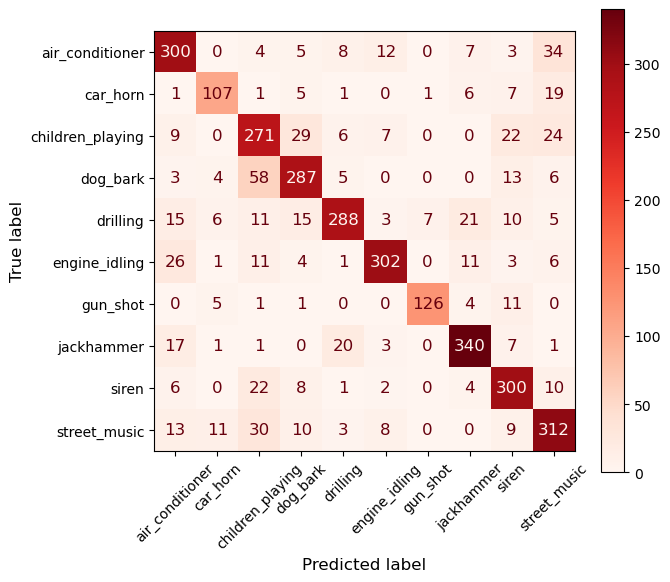

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.array(ty_test)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap='Reds', xticks_rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)
for text in disp.text_.ravel():
    text.set_fontsize(12)
plt.tight_layout()